In [1]:
import os
import random
import torch
import pandas as pd
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2
import numpy as np
from scipy import ndimage
from PIL import Image, UnidentifiedImageError
import warnings
import matplotlib.pyplot as plt

In [2]:
# Initialize SAM2 (assuming these are already defined in your environment)
checkpoint = "/Users/udiyamanshukla_1/Desktop/C_Drive/MSc_project/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint, device="cpu"))
consolidated_csv = 'consolidated_coordinates.csv'

In [3]:
# Updated function. Now look at cases where masks > 2 as well
def has_two_non_overlapping_regions(mask, min_size_ratio=0.5):
    """
    Check if mask has at least two non-overlapping regions where the largest two
    are roughly the same size.
    
    Args:
        mask (ndarray): Binary mask image
        min_size_ratio (float): Minimum ratio between smaller and larger region (default: 0.5)
        
    Returns:
        bool: True if the two largest regions meet the size ratio criteria
    """
    labeled_mask, num_features = ndimage.label(mask)
    
    # Need at least 2 regions to compare
    if num_features < 2:
        return False
    
    # Calculate sizes of all regions
    sizes = [np.sum(labeled_mask == i) for i in range(1, num_features + 1)]
    
    # Get indices of the two largest regions
    largest_two_indices = np.argsort(sizes)[-2:]
    size1, size2 = sizes[largest_two_indices[0]], sizes[largest_two_indices[1]]
    
    # Calculate size ratio (smaller/larger)
    size_ratio = min(size1, size2) / max(size1, size2)
    
    return size_ratio >= min_size_ratio


In [4]:


# def analyze_single_image(image_filename):
#     """
#     Analyze a single image with SAM2 using coordinates from CSV.
    
#     Args:
#         image_filename (str): Name of the image file to process
        
#     Returns:
#         dict: Analysis results including top 3 masks and evaluation details
#     """
#     try:
#         # Load coordinates from CSV
#         coord_df = pd.read_csv(consolidated_csv)
#         row = coord_df[coord_df['actual_filename'] == image_filename]
        
#         if row.empty:
#             return {'error': f"No coordinates found for {image_filename} in CSV"}
        
#         row = row.iloc[0]
#         lx, ly = int(row['abs_lx']), int(row['abs_ly'])
#         rx, ry = int(row['abs_rx']), int(row['abs_ry'])
        
#         # Find the actual image file (search in both blink and open directories)
#         image_path = None
#         for label in ['blink', 'open']:
#             test_path = os.path.join('Blink_tester' if label == 'blink' else 'Open_tester', image_filename)
#             if os.path.exists(test_path):
#                 image_path = test_path
#                 break
        
#         if not image_path:
#             return {'error': f"Image {image_filename} not found in either blink or open directories"}
        
#         # Load and validate image
#         with warnings.catch_warnings():
#             warnings.simplefilter("error")
#             image = cv2.imread(image_path)
#             if image is None:
#                 raise UnidentifiedImageError("OpenCV cannot read image")
#             image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
#         # Process with SAM2
#         predictor.set_image(image_rgb)
#         masks, scores, logits = predictor.predict(
#             point_coords=np.array([[lx, ly], [rx, ry]]),
#             point_labels=np.array([1, 1]),
#             multimask_output=True
#         )
        
#         # Get top 3 masks
#         top_indices = np.argsort(scores)[-3:][::-1]
#         top_masks = [masks[i] for i in top_indices]
#         top_scores = [scores[i] for i in top_indices]
#         top_areas = [int(np.sum(mask)) for mask in top_masks]
        
#         # Evaluate each mask against criteria
#         evaluations = []
#         criteria_met = False
#         best_mask_idx = 0  # Default to top scoring mask
        
#         for i, (mask, score, area) in enumerate(zip(top_masks, top_scores, top_areas)):
#             two_regions = has_two_non_overlapping_regions(mask)
#             size_ok = area < 75000
#             score_ok = score >= 0.1
#             meets_all = two_regions and size_ok and score_ok
            
#             evaluations.append({
#                 'rank': i+1,
#                 'score': float(score),
#                 'area': area,
#                 'has_two_regions': two_regions,
#                 'size_ok': size_ok,
#                 'score_ok': score_ok,
#                 'meets_all_criteria': meets_all
#             })
            
#             if meets_all and not criteria_met:
#                 criteria_met = True
#                 best_mask_idx = i
        
#         # Determine selection reason
#         if criteria_met:
#             if best_mask_idx == 0:
#                 selection_reason = "Highest scoring mask met all criteria"
#             else:
#                 selection_reason = f"Mask #{best_mask_idx+1} chosen by criteria (not highest scoring)"
#         else:
#             selection_reason = "No masks met all criteria - using highest scoring mask"
        
#         return {
#             'success': True,
#             'image_filename': image_filename,
#             'coordinates': {'lx': lx, 'ly': ly, 'rx': rx, 'ry': ry},
#             'top_masks': top_masks,
#             'evaluations': evaluations,
#             'best_mask_index': best_mask_idx,
#             'selection_reason': selection_reason,
#             'criteria_met': criteria_met
#         }
        
#     except Exception as e:
#         return {
#             'error': f"Processing error: {str(e)}",
#             'success': False
#         }

# def visualize_results(results):
#     """Visualize the analysis results."""
#     if not results['success']:
#         print(f"Error: {results['error']}")
#         return
    
#     print(f"\nAnalysis for image: {results['image_filename']}")
#     print(f"Eye coordinates - Left: ({results['coordinates']['lx']}, {results['coordinates']['ly']}), "
#           f"Right: ({results['coordinates']['rx']}, {results['coordinates']['ry']})")
    
#     print("\nTop 3 Masks Evaluation:")
#     for eval_info in results['evaluations']:
#         print(f"\nMask #{eval_info['rank']}:")
#         print(f"  Score: {eval_info['score']:.4f}")
#         print(f"  Area: {eval_info['area']}")
#         print(f"  Has two regions: {eval_info['has_two_regions']}")
#         print(f"  Size < 75000: {eval_info['size_ok']}")
#         print(f"  Score >= 0.1: {eval_info['score_ok']}")
#         print(f"  Meets all criteria: {eval_info['meets_all_criteria']}")
    
#     print(f"\nSelection: {results['selection_reason']}")
    
#     # Visualize masks
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     for i, (mask, ax) in enumerate(zip(results['top_masks'], axes)):
#         ax.imshow(mask, cmap='gray')
#         eval_info = results['evaluations'][i]
#         title = f"Mask #{i+1}\nScore: {eval_info['score']:.3f}\nArea: {eval_info['area']}"
#         if eval_info['meets_all_criteria']:
#             title += "\n(Meets all criteria)"
#         ax.set_title(title)
        
#         if i == results['best_mask_index']:
#             for spine in ax.spines.values():
#                 spine.set_color('green')
#                 spine.set_linewidth(3)
#     plt.tight_layout()
#     plt.show()

# # Example usage
# if __name__ == "__main__":
#     # Example - replace with your actual image filename
#     image_filename = "Open_tester/009/2022-09-28 15:04:21.292140-1416.jpg"  
    
#     # Analyze the image
#     analysis_results = analyze_single_image(image_filename)
    
#     # Visualize and print results
#     visualize_results(analysis_results)

Enter image filename (e.g., 'example_blink.jpg'):  2022-11-14 10:23:25.030881-55.jpg
Enter path to image directory:  Open_tester/071



Analysis for image: 2022-11-14 10:23:25.030881-55.jpg
Eye coordinates - Left: (297, 532), Right: (732, 528)

Top 3 Masks Evaluation:

Mask #1:
  Score: 0.7435
  Area: 233912
  Has two regions: False
  Size < 75000: False
  Score >= 0.1: True
  Meets all criteria: False

Mask #2:
  Score: 0.6459
  Area: 375052
  Has two regions: False
  Size < 75000: False
  Score >= 0.1: True
  Meets all criteria: False

Mask #3:
  Score: 0.0430
  Area: 13387
  Has two regions: True
  Size < 75000: True
  Score >= 0.1: False
  Meets all criteria: False

Selection: No masks met all criteria - using highest scoring mask


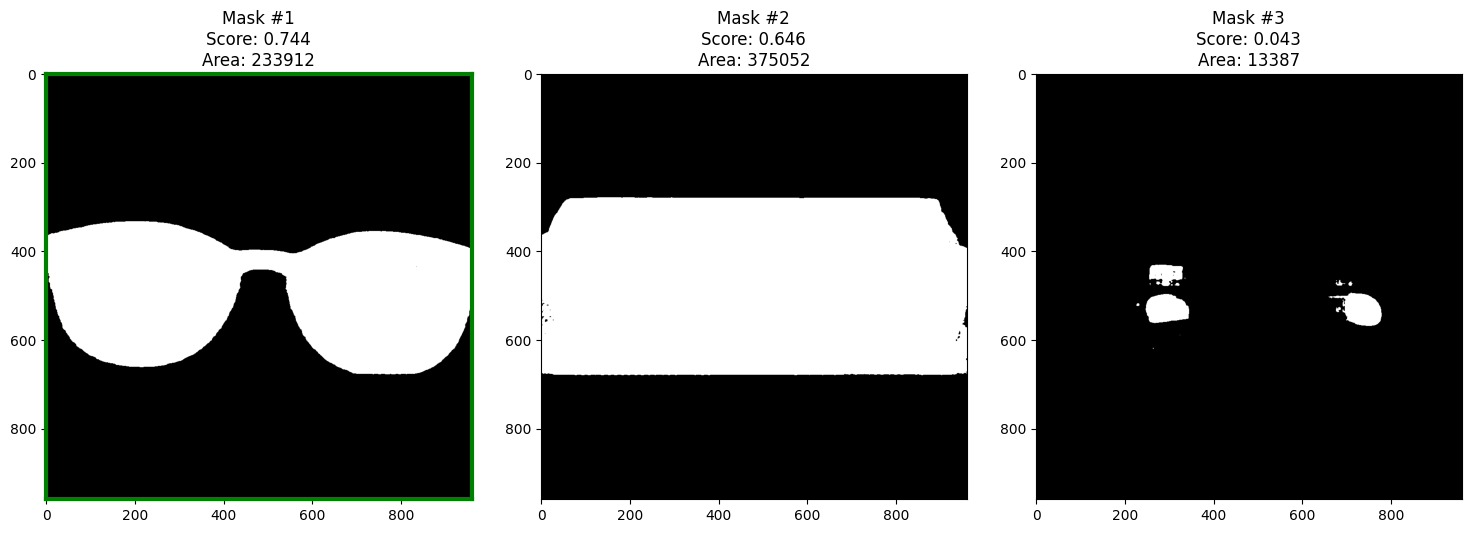

In [9]:
def analyze_single_image(image_filename, image_path):
    """
    Analyze a single image with SAM2 using coordinates from CSV.
    
    Args:
        image_filename (str): Name of the image file to process
        image_path (str): Path to directory containing the image
        
    Returns:
        dict: Analysis results including top 3 masks and evaluation details
             Always contains 'success' key (bool) and 'error' key if unsuccessful
    """
    try:
        # First ensure we have the success key in all return paths
        result_template = {'success': False, 'error': None}
        
        # Load coordinates from CSV
        try:
            coord_df = pd.read_csv(consolidated_csv)
        except Exception as e:
            result_template['error'] = f"Failed to load CSV: {str(e)}"
            return result_template
            
        row = coord_df[coord_df['actual_filename'] == image_filename]
        
        if row.empty:
            result_template['error'] = f"No coordinates found for {image_filename} in CSV"
            return result_template
        
        row = row.iloc[0]
        try:
            lx, ly = int(row['abs_lx']), int(row['abs_ly'])
            rx, ry = int(row['abs_rx']), int(row['abs_ry'])
        except (ValueError, KeyError) as e:
            result_template['error'] = f"Invalid coordinates in CSV: {str(e)}"
            return result_template
        
        # Construct full image path
        full_image_path = os.path.join(image_path, image_filename)
        if not os.path.exists(full_image_path):
            result_template['error'] = f"Image not found at {full_image_path}"
            return result_template
        
        # Load and validate image
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                image = cv2.imread(full_image_path)
                if image is None:
                    raise UnidentifiedImageError("OpenCV cannot read image")
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            result_template['error'] = f"Image loading failed: {str(e)}"
            return result_template
        
        # Process with SAM2
        try:
            predictor.set_image(image_rgb)
            masks, scores, logits = predictor.predict(
                point_coords=np.array([[lx, ly], [rx, ry]]),
                point_labels=np.array([1, 1]),
                multimask_output=True
            )
        except Exception as e:
            result_template['error'] = f"SAM2 processing failed: {str(e)}"
            return result_template
        
        # Get top 3 masks
        top_indices = np.argsort(scores)[-3:][::-1]
        top_masks = [masks[i] for i in top_indices]
        top_scores = [scores[i] for i in top_indices]
        top_areas = [int(np.sum(mask)) for mask in top_masks]
        
        # Evaluate each mask against criteria
        evaluations = []
        criteria_met = False
        best_mask_idx = 0
        
        for i, (mask, score, area) in enumerate(zip(top_masks, top_scores, top_areas)):
            two_regions = has_two_non_overlapping_regions(mask)
            size_ok = area < 75000
            score_ok = score >= 0.05
            meets_all = two_regions and size_ok and score_ok
            
            evaluations.append({
                'rank': i+1,
                'score': float(score),
                'area': area,
                'has_two_regions': two_regions,
                'size_ok': size_ok,
                'score_ok': score_ok,
                'meets_all_criteria': meets_all
            })
            
            if meets_all and not criteria_met:
                criteria_met = True
                best_mask_idx = i
        
        # Prepare successful result
        return {
            'success': True,
            'image_filename': image_filename,
            'image_path': full_image_path,
            'coordinates': {'lx': lx, 'ly': ly, 'rx': rx, 'ry': ry},
            'top_masks': top_masks,
            'evaluations': evaluations,
            'best_mask_index': best_mask_idx,
            'selection_reason': (
                f"Mask #{best_mask_idx+1} chosen by criteria" if criteria_met and best_mask_idx != 0 else
                "Highest scoring mask met all criteria" if criteria_met else
                "No masks met all criteria - using highest scoring mask"
            ),
            'criteria_met': criteria_met
        }
        
    except Exception as e:
        return {
            'success': False,
            'error': f"Unexpected error: {str(e)}"
        }

def visualize_results(results):
    """Visualize the analysis results."""
    if not results['success']:
        print(f"Error: {results['error']}")
        return
    
    print(f"\nAnalysis for image: {results['image_filename']}")
    print(f"Eye coordinates - Left: ({results['coordinates']['lx']}, {results['coordinates']['ly']}), "
          f"Right: ({results['coordinates']['rx']}, {results['coordinates']['ry']})")
    
    print("\nTop 3 Masks Evaluation:")
    for eval_info in results['evaluations']:
        print(f"\nMask #{eval_info['rank']}:")
        print(f"  Score: {eval_info['score']:.4f}")
        print(f"  Area: {eval_info['area']}")
        print(f"  Has two regions: {eval_info['has_two_regions']}")
        print(f"  Size < 75000: {eval_info['size_ok']}")
        print(f"  Score >= 0.1: {eval_info['score_ok']}")
        print(f"  Meets all criteria: {eval_info['meets_all_criteria']}")
    
    print(f"\nSelection: {results['selection_reason']}")
    
    # Visualize masks
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, (mask, ax) in enumerate(zip(results['top_masks'], axes)):
        ax.imshow(mask, cmap='gray')
        eval_info = results['evaluations'][i]
        title = f"Mask #{i+1}\nScore: {eval_info['score']:.3f}\nArea: {eval_info['area']}"
        if eval_info['meets_all_criteria']:
            title += "\n(Meets all criteria)"
        ax.set_title(title)
        
        if i == results['best_mask_index']:
            for spine in ax.spines.values():
                spine.set_color('green')
                spine.set_linewidth(3)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    try:
        # Get user input
        image_filename = input("Enter image filename (e.g., 'example_blink.jpg'): ").strip()
        image_path = input("Enter path to image directory: ").strip()
        
        # Analyze the image
        analysis_results = analyze_single_image(image_filename, image_path)
        
        # Visualize and print results
        visualize_results(analysis_results)
    except Exception as e:
        print(f"An error occurred: {str(e)}")

## 2022-09-28 15:24:54.576677-1634

In [ ]:
# 2022-10-17 11:18:10.759307-1977.jpg
Use for annotation of eye centers

/var/folders/09/8ljzfvcs0cg5dzgncd1pqmrr0000gp/T/ipykernel_29831/4105075054.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  lx, ly = int(row['abs_lx']), int(row['abs_ly'])
/var/folders/09/8ljzfvcs0cg5dzgncd1pqmrr0000gp/T/ipykernel_29831/4105075054.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  rx, ry = int(row['abs_rx']), int(row['abs_ry'])


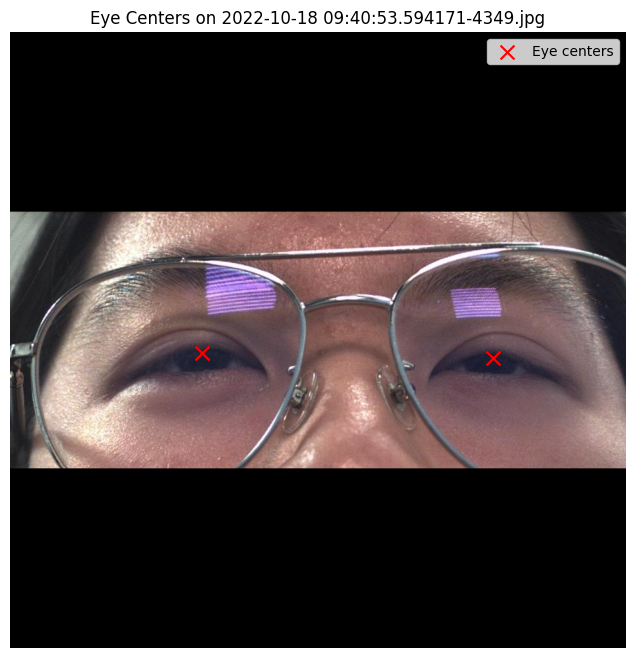

In [2]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Parameters
root_folder = "Open_eyes_dataset_flat_test"  # parent folder with subfolders
image_name = "2022-10-18 09:40:53.594171-4349.jpg"
csv_path = "consolidated_coordinates.csv"

# === Step 1: Read CSV and extract coordinates ===
coord_df = pd.read_csv(csv_path)
row = coord_df[coord_df['actual_filename'] == image_name]

if row.empty:
    raise FileNotFoundError(f"No coordinates found in CSV for {image_name}")

lx, ly = int(row['abs_lx']), int(row['abs_ly'])
rx, ry = int(row['abs_rx']), int(row['abs_ry'])

# === Step 2: Search for image file in subfolders ===
img_path = None
for subfolder in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder)
    if os.path.isdir(subfolder_path):
        candidate_path = os.path.join(subfolder_path, image_name)
        if os.path.isfile(candidate_path):
            img_path = candidate_path
            break

if img_path is None:
    raise FileNotFoundError(f"Image {image_name} not found in {root_folder}")

# === Step 3: Load image ===
image_bgr = cv2.imread(img_path)
if image_bgr is None:
    raise IOError(f"Could not read image at {img_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === Step 4: Annotate eye centers ===
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.scatter([lx, rx], [ly, ry], c='red', s=100, marker='x', label="Eye centers")
plt.title(f"Eye Centers on {image_name}")
plt.legend()
plt.axis('off')
plt.show()
